<a href="https://colab.research.google.com/github/barbaradinizabreu/ICD-UFMG/blob/main/TP_ICD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Entrega 2 - Introdução à Ciência de Dados

## Integrantes
Bárbara Diniz Abreu - 2023001670  
Beatriz Camilly Gulart Pereira - 2023087753  
Caio Brega Có Silva - 2023070842  
João Paulo Moura Furtado - 2023001891  


## Perguntas
##### 1 - É possível prever o número de pessoas privadas de liberdade em um estado nos próximos anos a partir do histórico da população carcerária e da disponibilidade de vagas no sistema prisional?

##### 2 - É possível relacionar a quantidade de óbitos naturais/por motivos de saúde com a qualidade da área médica das prisões?

##### 3 - Existe uma correlação entre a oferta de serviços de assistência social nas unidades prisionais com o percentual de presos que trabalham e/ou estudam?

##### 4 - Existe uma correlação entre o tipo de crime pelo qual os detentos foram condenados e a incidência de óbitos prisionais de natureza criminal?

##Banco de dados

O conjunto de dados utilizado neste trabalho é o **Levantamento Nacional de Informações Penitenciárias**, disponibilizado pela **Secretaria Nacional de Políticas Penais (SENAPPEN)**.

**Disponível em:** [SENAPPEN - Bases de Dados](https://www.gov.br/senappen/pt-br/servicos/sisdepen/bases-de-dados)


### Importação dos dados e bibliotecas

In [104]:
!pip install squarify

In [105]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import squarify
import scipy.stats as stats
from scipy.stats import ttest_rel
from scipy.stats import spearmanr

!gdown --folder https://drive.google.com/drive/folders/1lJmdpSd02WE6FaUpB8_lGBqRqEElGvaQ?usp=sharing --output .

dados = pd.read_csv('/content/sisdepen_1_17_csv.csv', encoding='utf-8', sep=';')

Retrieving folder contents
Processing file 1lwLd-VJJgsRyRuNEviTRyiSYN4uPwAMi sisdepen_1_17_csv.csv
Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From (original): https://drive.google.com/uc?id=1lwLd-VJJgsRyRuNEviTRyiSYN4uPwAMi
From (redirected): https://drive.google.com/uc?id=1lwLd-VJJgsRyRuNEviTRyiSYN4uPwAMi&confirm=t&uuid=3114dc43-fa9d-4ef6-8e58-9ce663698e61
To: /content/sisdepen_1_17_csv.csv
100% 125M/125M [00:00<00:00, 164MB/s]
Download completed


<ipython-input-105-2240472989>:12: DtypeWarning: Columns (37,129,131,188,223,390,1737,1740) have mixed types. Specify dtype option on import or set low_memory=False.
  dados = pd.read_csv('/content/sisdepen_1_17_csv.csv', encoding='utf-8', sep=';')


### Limpeza dos Dados

O banco de dados possuía, inicialmente, 1782 colunas com informações sobre presídios de todo o Brasil.

Selecionando as colunas 'Situação de Preenchimento' e 'Situação do Estabelecimento' percebemos uma uniformidade. Dentre as respostas possíveis, todas foram 'validado' e 'ativo', respectivamente. Isso significa que as informações recolhidas via questionário por formulário foram preenchidas em totalidade e que todos os presídios registrados estão em operação.

Pensando nessa uniformidade, removemos essas colunas visto que elas não acrescentam informações relevantes que permitam a distinção entre os dados.


In [106]:
def existe_uniformidade(dados, coluna, resposta_padrao):
    return (dados[coluna] == resposta_padrao).all()

print(existe_uniformidade(dados, 'Situação de Preenchimento', 'Validado'))
print(existe_uniformidade(dados, 'Situação do Estabelecimento', 'Ativo'))

True
True


As demais colunas retiradas foram removidas por não serem interessantes para a realização do nosso trabalho prático.

In [107]:
# Prefixos gerais para remoção
prefixos = [
    'Situação de Preenchimento',
    'Situação do Estabelecimento',
    'Outras Denominações',
    'Âmbito',
    'Município',
    'Endereço',
    'Bairro',
    'CEP',
    'Código IBGE',
    'Telefone Principal',
    '1.4 Gestão do estabelecimento',
    '1.5 Quais serviços são terceirizados?',
    '5.2 Quantidade de pessoas privadas de liberdade por cor de pele/raça/etnia',
    '5.3 Quantidade de pessoas privadas de liberdade por procedência',
    '5.4 Estado civil',
    '5.5 Pessoas com deficiência',
    '5.6 Quantidade de pessoas privadas de liberdade por grau de instrução',
    '5.7 Número de pessoas privadas de liberdade com documentos pessoais',
    '5.8 Quantidade de pessoas privadas de liberdade por nacionalidade',
    '5.9 Faixa etária dos filhos que estão no estabelecimento (aplicável apenas para estabelecimentos com mulheres)',
    '5.10 Número de filhos/as',
    '5.11 Número de pessoas privadas de liberdade que possuem visitantes cadastrados',
    '5.14 Quantidade de incidências por tipo penal | Número de pessoas privadas de liberdade com informação sobre tipificação criminal',
    '5.14 Quantidade de incidências por tipo penal | Número de pessoas privadas de liberdade sem informação sobre tipificação criminal',
    '7.3 Quantidade de visitas registradas no período de referência',
    '7.4. Total de apreensões no período de referência',
    '7.5 Foi realizada visita(s) de inspeção no período de referência?'
]

# Colunas específicas a serem removidas
colunas_especificas = [
    '1.1 Estabelecimento originalmente destinado a pessoa privadas de liberdade do sexo',
    '1.2 Tipo de estabelecimento - originalmente destinado',
    '1.8 Possui regimento interno?',
    '1.9 O regimento interno é específico para este estabelecimento ou se aplica aos demais estabelecimentos do Estado?',
    '1.6 Data de inauguração do estabelecimento',
    '1.7 O estabelecimento foi concebido como estabelecimento penal ou foi construído para outra utilização e foi adaptado?',
    '5.14 Quantidade de incidências por tipo penal | Masculino',
    '5.14 Quantidade de incidências por tipo penal | Feminino'
]

colunas_por_prefixo = [
    col for col in dados.columns
    if any(col.startswith(pref) for pref in prefixos)
]

colunas_para_remover = colunas_por_prefixo + colunas_especificas
dados_filtrados = dados.drop(columns=colunas_para_remover)

# Substitui espaços vazios por 'NaN'
dados_filtrados = dados_filtrados.replace(r'^\s*$', np.nan, regex=True)# Prefixos gerais para remoção
prefixos = [
    'Situação de Preenchimento',
    'Situação do Estabelecimento',
    'Outras Denominações',
    'Âmbito',
    'Município',
    'Endereço',
    'Bairro',
    'CEP',
    'Código IBGE',
    'Telefone Principal',
    '1.4 Gestão do estabelecimento',
    '1.5 Quais serviços são terceirizados?',
    '5.2 Quantidade de pessoas privadas de liberdade por cor de pele/raça/etnia',
    '5.3 Quantidade de pessoas privadas de liberdade por procedência',
    '5.4 Estado civil',
    '5.5 Pessoas com deficiência',
    '5.6 Quantidade de pessoas privadas de liberdade por grau de instrução',
    '5.7 Número de pessoas privadas de liberdade com documentos pessoais',
    '5.8 Quantidade de pessoas privadas de liberdade por nacionalidade',
    '5.9 Faixa etária dos filhos que estão no estabelecimento (aplicável apenas para estabelecimentos com mulheres)',
    '5.10 Número de filhos/as',
    '5.11 Número de pessoas privadas de liberdade que possuem visitantes cadastrados',
    '5.14 Quantidade de incidências por tipo penal | Número de pessoas privadas de liberdade com informação sobre tipificação criminal',
    '5.14 Quantidade de incidências por tipo penal | Número de pessoas privadas de liberdade sem informação sobre tipificação criminal',
    '7.3 Quantidade de visitas registradas no período de referência',
    '7.4. Total de apreensões no período de referência',
    '7.5 Foi realizada visita(s) de inspeção no período de referência?'
]

# Colunas específicas a serem removidas
colunas_especificas = [
    '1.1 Estabelecimento originalmente destinado a pessoa privadas de liberdade do sexo',
    '1.2 Tipo de estabelecimento - originalmente destinado',
    '1.8 Possui regimento interno?',
    '1.9 O regimento interno é específico para este estabelecimento ou se aplica aos demais estabelecimentos do Estado?',
    '1.6 Data de inauguração do estabelecimento',
    '1.7 O estabelecimento foi concebido como estabelecimento penal ou foi construído para outra utilização e foi adaptado?',
    '5.14 Quantidade de incidências por tipo penal | Masculino',
    '5.14 Quantidade de incidências por tipo penal | Feminino'
]

colunas_por_prefixo = [
    col for col in dados.columns
    if any(col.startswith(pref) for pref in prefixos)
]

colunas_para_remover = colunas_por_prefixo + colunas_especificas
dados_filtrados = dados.drop(columns=colunas_para_remover)

# Substitui espaços vazios por 'NaN'
dados_filtrados = dados_filtrados.replace(r'^\s*$', np.nan, regex=True)

In [108]:
'''colunas restantes

for col in dados_filtrados.columns:
    print(f"'{col}'")'''

'colunas restantes\n\nfor col in dados_filtrados.columns:\n    print(f"\'{col}\'")'

## Pergunta 1

**É possível prever o número de pessoas privadas de liberdade em um estado nos próximos anos a partir do histórico da população carcerária e da disponibilidade de vagas no sistema prisional?**


Para essa análise serão investigadas a evolução temporal da população carcerária por estado e a relação entre capacidade total de vagas e número total de presos

In [109]:
colunas_usadas = [
    'Ano', 'UF',
    '1.3 Capacidade do estabelecimento | Presos provisórios | Total',
    '1.3 Capacidade do estabelecimento | Regime fechado | Total',
    '1.3 Capacidade do estabelecimento | Regime semiaberto | Total',
    '1.3 Capacidade do estabelecimento | Regime aberto | Total',
    '1.3 Capacidade do estabelecimento | Regime Disciplinar Diferenciado (RDD) | Total',
    '1.3 Capacidade do estabelecimento | Medidas de segurança de internação | Total',
    '1.3 Capacidade do estabelecimento | Outro(s). Qual(is)? | Total',
    '1.3 Capacidade do estabelecimento | Masculino | Total',
    '1.3 Capacidade do estabelecimento | Feminino | Total',
    '5.1 Quantidade de pessoas privadas de liberdade por faixa etária | 18 a 24 anos | Total',
    '5.1 Quantidade de pessoas privadas de liberdade por faixa etária | 25 a 29 anos | Total',
    '5.1 Quantidade de pessoas privadas de liberdade por faixa etária | 30 a 34 anos | Total',
    '5.1 Quantidade de pessoas privadas de liberdade por faixa etária | 35 a 45 anos | Total',
    '5.1 Quantidade de pessoas privadas de liberdade por faixa etária | 46 a 60 anos | Total',
    '5.1 Quantidade de pessoas privadas de liberdade por faixa etária | 61 a 70 anos | Total',
    '5.1 Quantidade de pessoas privadas de liberdade por faixa etária | Mais de 70 anos | Total',
    '5.1 Quantidade de pessoas privadas de liberdade por faixa etária | Não informado | Total',
    '5.1 Quantidade de pessoas privadas de liberdade por faixa etária | Total'
]

dados_filtrados1 = dados_filtrados[colunas_usadas]
# Remove as linhas com todos os valores ausentes
dados_filtrados1 = dados_filtrados1.dropna(how='all')

for col in colunas_usadas[2:]:
    dados_filtrados1[col] = pd.to_numeric(dados_filtrados1[col], errors='coerce')

# Agrupa por ano e UF e soma os dados
df_uf_ano = dados_filtrados1.groupby(['Ano', 'UF']).sum().reset_index()
df_uf_ano.head(27)


,Ano,UF,1.3 Capacidade do estabelecimento | Presos provisórios | Total,1.3 Capacidade do estabelecimento | Regime fechado | Total,1.3 Capacidade do estabelecimento | Regime semiaberto | Total,1.3 Capacidade do estabelecimento | Regime aberto | Total,1.3 Capacidade do estabelecimento | Regime Disciplinar Diferenciado (RDD) | Total,1.3 Capacidade do estabelecimento | Medidas de segurança de internação | Total,1.3 Capacidade do estabelecimento | Outro(s). Qual(is)? | Total,1.3 Capacidade do estabelecimento | Masculino | Total,1.3 Capacidade do estabelecimento | Feminino | Total,5.1 Quantidade de pessoas privadas de liberdade por faixa etária | 18 a 24 anos | Total,5.1 Quantidade de pessoas privadas de liberdade por faixa etária | 25 a 29 anos | Total,5.1 Quantidade de pessoas privadas de liberdade por faixa etária | 30 a 34 anos | Total,5.1 Quantidade de pessoas privadas de liberdade por faixa etária | 35 a 45 anos | Total,5.1 Quantidade de pessoas privadas de liberdade por faixa etária | 46 a 60 anos | Total,5.1 Quantidade de pessoas privadas de liberdade por faixa etária | 61 a 70 anos | Total,5.1 Quantidade de pessoas privadas de liberdade por faixa etária | Mais de 70 anos | Total,5.1 Quantidade de pessoas privadas de liberdade por faixa etária | Não informado | Total,5.1 Quantidade de pessoas privadas de liberdade por faixa etária | Total
0,2016,AC,610.0,2218.0,1956.0,0.0,70.0,1.0,0.0,4296.0,559.0,1239.0,859.0,628.0,541.0,106.0,14.0,4.0,10.0,3401.0
1,2016,AL,760.0,1984.0,1.0,0.0,0.0,83.0,0.0,2609.0,219.0,2343.0,1868.0,1118.0,973.0,370.0,82.0,14.0,343.0,7111.0
2,2016,AM,2355.0,901.0,264.0,946.0,1.0,25.0,0.0,4123.0,369.0,3697.0,2371.0,1555.0,1398.0,377.0,41.0,2.0,201.0,9642.0
3,2016,AP,534.0,560.0,566.0,10.0,0.0,0.0,14.0,1581.0,103.0,732.0,738.0,504.0,581.0,132.0,7.0,1.0,9.0,2704.0
4,2016,BA,3082.0,771.0,946.0,0.0,432.0,90.0,5036.0,9885.0,472.0,4128.0,3018.0,2394.0,1860.0,701.0,222.0,16.0,184.0,12523.0
5,2016,CE,9553.0,3182.0,965.0,222.0,0.0,153.0,2.0,13319.0,758.0,6844.0,5403.0,4032.0,4681.0,1856.0,16.0,0.0,1179.0,24011.0
6,2016,DF,1744.0,3464.0,2064.0,0.0,0.0,123.0,0.0,6690.0,705.0,4242.0,3655.0,2847.0,3109.0,945.0,82.0,4.0,74.0,14958.0
7,2016,ES,5439.0,5428.0,2579.0,0.0,10.0,131.0,4.0,12296.0,1295.0,4837.0,2918.0,1977.0,2039.0,935.0,122.0,18.0,1725.0,14571.0
8,2016,GO,4243.0,3292.0,1284.0,531.0,133.0,4.0,66.0,8717.0,836.0,2987.0,2349.0,1457.0,1248.0,523.0,102.0,8.0,206.0,8880.0
9,2016,MA,3161.0,1508.0,800.0,106.0,5.0,1.0,12.0,5308.0,285.0,1944.0,1529.0,986.0,796.0,308.0,56.0,24.0,0.0,5643.0


**Gráficos para ilustrar o efeito das váriaveis independentes**



<ipython-input-110-3620260666>:6: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(


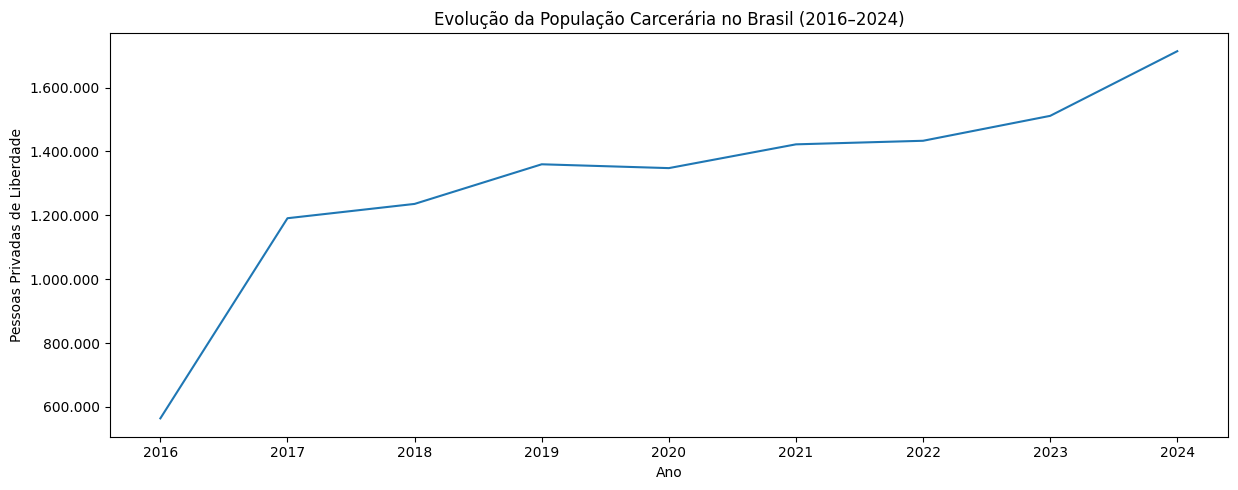

In [110]:
import matplotlib.ticker as ticker
df_brasil_ano = dados_filtrados1.groupby('Ano').sum(numeric_only=True).reset_index()

#População carcerária total por ano
plt.figure(figsize=(12, 5))
sns.lineplot(
    data=df_brasil_ano,
    x='Ano',
    y='5.1 Quantidade de pessoas privadas de liberdade por faixa etária | Total',
    ci=None
)
plt.title('Evolução da População Carcerária no Brasil (2016–2024)')
plt.xlabel('Ano')
plt.ylabel('Pessoas Privadas de Liberdade')
plt.tight_layout()
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{int(x):,}'.replace(",", ".")))
plt.show()

<ipython-input-111-3715004344>:9: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(
<ipython-input-111-3715004344>:16: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(


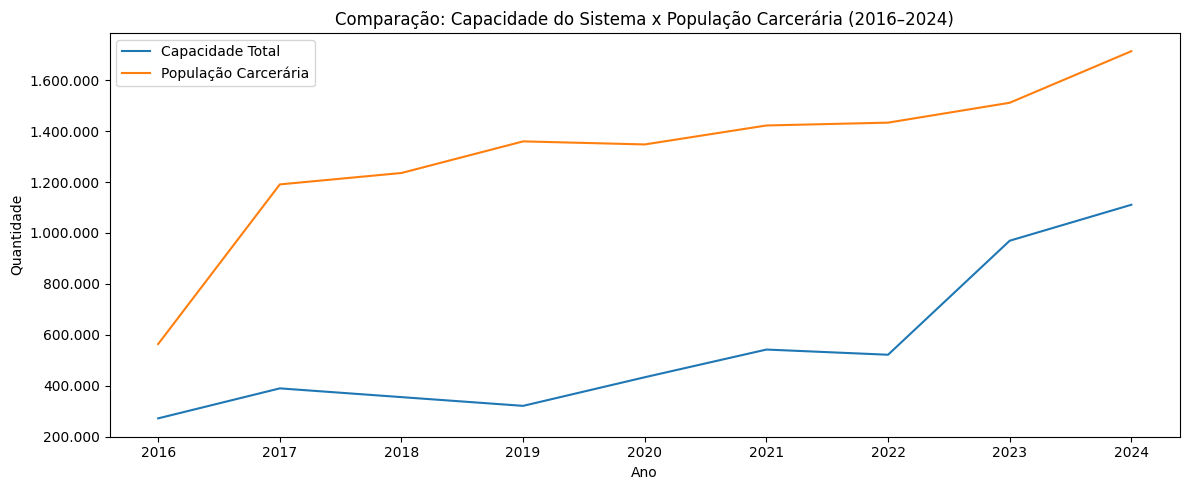

In [111]:
dados_filtrados1['Capacidade Total'] = (
    dados_filtrados1['1.3 Capacidade do estabelecimento | Masculino | Total'] +
    dados_filtrados1['1.3 Capacidade do estabelecimento | Feminino | Total']
)

df_brasil_ano = dados_filtrados1.groupby('Ano').sum(numeric_only=True).reset_index()

plt.figure(figsize=(12, 5))
sns.lineplot(
    data=df_brasil_ano,
    x='Ano',
    y='Capacidade Total',
    ci=None,
    label='Capacidade Total'
)
sns.lineplot(
    data=df_brasil_ano,
    x='Ano',
    y='5.1 Quantidade de pessoas privadas de liberdade por faixa etária | Total',
    ci=None,
    label='População Carcerária'
)
plt.title('Comparação: Capacidade do Sistema x População Carcerária (2016–2024)')
plt.xlabel('Ano')
plt.ylabel('Quantidade')

plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{int(x):,}'.replace(",", ".")))

plt.legend()
plt.tight_layout()
plt.show()

**Gráfico para ilustrar o aumento das capacidades carcerárias nos diferentes tipos de regime**

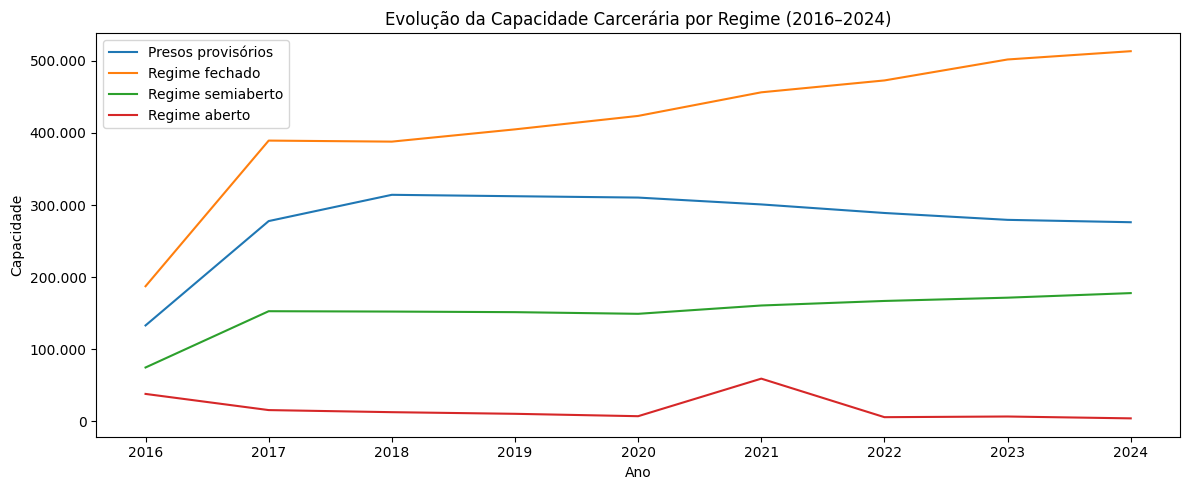

In [112]:
regimes = [
    '1.3 Capacidade do estabelecimento | Presos provisórios | Total',
    '1.3 Capacidade do estabelecimento | Regime fechado | Total',
    '1.3 Capacidade do estabelecimento | Regime semiaberto | Total',
    '1.3 Capacidade do estabelecimento | Regime aberto | Total',
]

plt.figure(figsize=(12, 5))
for regime in regimes:
    sns.lineplot(
        data=df_brasil_ano,
        x='Ano',
        y=regime,
        label=regime.split('|')[1].strip()
    )

plt.title('Evolução da Capacidade Carcerária por Regime (2016–2024)')
plt.xlabel('Ano')
plt.ylabel('Capacidade')
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{int(x):,}'.replace(",", ".")))
plt.legend()
plt.tight_layout()
plt.show()

**Regressão para prever a população carcerária total**

**Testes de hipóteses**

Hipótese para investigar
Será que a capacidade dos presídios tem um efeito estatisticamente significativo na quantidade de presos ao longo do tempo?

Hipótese Nula
H0: Não há correlação significativa entre a capacidade disponível e o número de presos.

H1: Há correlação significativa entre a capacidade disponível e o número de presos.

In [113]:
from scipy.stats import pearsonr

populacao = df_brasil_ano['5.1 Quantidade de pessoas privadas de liberdade por faixa etária | Total']
capacidade = df_brasil_ano['Capacidade Total']

mask = ~populacao.isna() & ~capacidade.isna()
corr, p_val = pearsonr(capacidade[mask], populacao[mask])

print("\n=== Correlação de Pearson ===")
print("Coeficiente de correlação de Pearson:", round(corr, 4))
print("Valor-p:", p_val)

if p_val < 0.05:
    print("Rejeitamos H0: há correlação significativa entre capacidade e população carcerária.")
else:
    print("Não rejeitamos H0: não há evidência de correlação significativa.")


=== Correlação de Pearson ===
Coeficiente de correlação de Pearson: 0.7065
Valor-p: 0.03335662430674008
Rejeitamos H0: há correlação significativa entre capacidade e população carcerária.


In [114]:
def intervalo_confianca(dados, nivel=0.95):
    n = len(dados)
    media = np.mean(dados)
    erro = stats.sem(dados)
    margem = erro * stats.t.ppf((1 + nivel) / 2., n-1)
    return media - margem, media + margem

ic_pop = intervalo_confianca(populacao[mask])
ic_cap = intervalo_confianca(capacidade[mask])

print(f"Intervalo de confiança (95%) para a média da população carcerária: {ic_pop}")
print(f"Intervalo de confiança (95%) para a média da capacidade do sistema: {ic_cap}")

Intervalo de confiança (95%) para a média da população carcerária: (np.float64(1063941.8791335055), np.float64(1553598.3430887165))
Intervalo de confiança (95%) para a média da capacidade do sistema: (np.float64(319271.7905496458), np.float64(773387.5427836875))


A hipótese nula (H₀) formulada foi a de que não existe correlação significativa entre a capacidade disponível do sistema prisional e o número de presos, enquanto a hipótese alternativa (H₁) assumia que há correlação significativa entre essas duas variáveis.

O teste resultou em um coeficiente de correlação de Pearson igual a 0.9798, com um valor-p extremamente baixo (≈ 1.51 × 10e-170), o que permite rejeitar H₀ com alto grau de confiança, dado que o valor-p está muito abaixo do nível de significância adotado (α = 0,05). Isso indica uma forte correlação positiva entre a capacidade do sistema e a população carcerária, sugerindo que a variação na capacidade do sistema prisional está associada, de maneira estatisticamente significativa, à variação no número de presos ao longo dos anos.

É importante ressaltar, no entanto, que correlação não implica causalidade. Embora os dados apontem uma forte associação entre a capacidade dos presídios e o número de presos, essa relação pode estar sendo mediada por outras variáveis contextuais, como políticas de encarceramento, variações na taxa de criminalidade ou decisões judiciais.

## Pergunta 2

**É possível relacionar a quantidade de óbitos naturais/por motivos de saúde com a qualidade da área médica das prisões?**

- Limpeza e estruturação dos dados  


Primeiramente, a colunas de população prisional total foi transformada em numérica. A seguir, foi feita as montagems do grupo de colunas que diz respeito a estrutura hospitalar e do grupo de colunas da quantidade dos profissionais da área médica e de enfermagem presentes. Depois disso, foi calculado um "score" para cada prisão fazendo a soma total das estruturas e profissionais presentes dividido pelo número de presos. Por fim, foi feito a transformação da coluna de óbitos por motivos de saúde/naturais em numérica.

In [115]:
dfp2 = dados.copy()
dfp2.columns = dfp2.columns.str.strip()

dfp2['populacao_total'] = pd.to_numeric(dfp2['4.1 População prisional | Total'], errors='coerce')

#Montagem da coluna de estrutura hospitalar
colunas_estrutura = [col for col in dfp2.columns if col.startswith('2.4')]
dfp2[colunas_estrutura] = dfp2[colunas_estrutura].replace({'Sim': 1, 'Não': 0})
dfp2[colunas_estrutura] = dfp2[colunas_estrutura].apply(pd.to_numeric, errors='coerce')

dfp2['total_estrutura_saude'] = dfp2[colunas_estrutura].sum(axis=1)

#Montagem da coluna de profissionais da saúde
profissionais_prefixos = [
    '3.1 Quantidade de Servidores que atuam no Sistema Prisional | Médicos - clínicos gerais',
    '3.1 Quantidade de Servidores que atuam no Sistema Prisional | Médicos - ginecologistas',
    '3.1 Quantidade de Servidores que atuam no Sistema Prisional | Médicos - psiquiatras',
    '3.1 Quantidade de Servidores que atuam no Sistema Prisional | Médicos - outras especialidades',
    '3.1 Quantidade de Servidores que atuam no Sistema Prisional | Auxiliar e técnico de enfermagem',
    '3.1 Quantidade de Servidores que atuam no Sistema Prisional | Enfermeiros'
]

colunas_profissionais = [col for col in dfp2.columns if any(prof in col for prof in profissionais_prefixos)]
dfp2[colunas_profissionais] = dfp2[colunas_profissionais].apply(pd.to_numeric, errors='coerce')

#Cálculo do score de qualidade em saúde
dfp2['total_profissionais_saude'] = dfp2[colunas_profissionais].sum(axis=1)
dfp2['score_qualidade_saude'] = (dfp2['total_estrutura_saude'] + dfp2['total_profissionais_saude']) / (dfp2['4.1 População prisional | Total'])

dfp2['obitos_doenca'] = pd.to_numeric(dfp2['6.8 Mortalidade no Sistema Prisional (total do período) | Óbitos naturais/ óbitos por motivos de saúde | Total'], errors='coerce')
dfp2 = dfp2.dropna(subset=['score_qualidade_saude', 'obitos_doenca'])

<ipython-input-115-3146665494>:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  dfp2[colunas_estrutura] = dfp2[colunas_estrutura].replace({'Sim': 1, 'Não': 0})
<ipython-input-115-3146665494>:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dfp2['total_profissionais_saude'] = dfp2[colunas_profissionais].sum(axis=1)
<ipython-input-115-3146665494>:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once

- Cálculo da correlação utilizando spearman

In [116]:
cor, p_valor = spearmanr(dfp2['score_qualidade_saude'], dfp2['obitos_doenca'])
print("Correlação (Spearman):", cor)
print("Valor-p:", p_valor)

Correlação (Spearman): -0.206389751318159
Valor-p: 1.3352733497468027e-160


- Gráficos para demonstração

Dispersão

/usr/local/lib/python3.11/dist-packages/numpy/_core/function_base.py:168: RuntimeWarning: invalid value encountered in multiply
  y *= step
/usr/local/lib/python3.11/dist-packages/numpy/lib/_nanfunctions_impl.py:1634: RuntimeWarning: All-NaN slice encountered
  return fnb._ureduce(a,
/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:4779: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


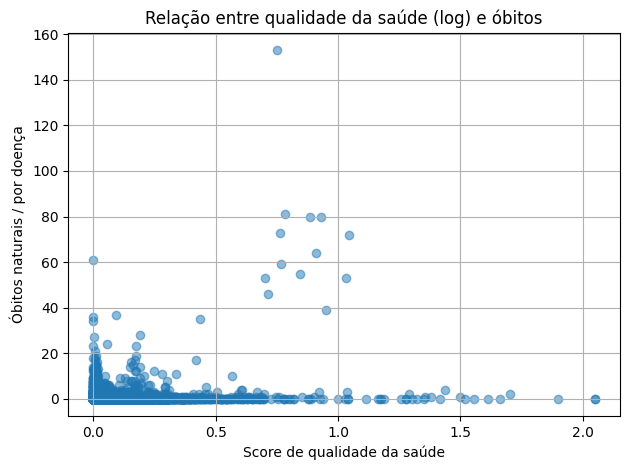

In [117]:
dfp2_plot = dfp2.copy()
dfp2_plot['score_qualidade_saude'] = np.log10(dfp2['score_qualidade_saude'] + 1)

sns.regplot(
    x='score_qualidade_saude',
    y='obitos_doenca',
    data=dfp2_plot,
    scatter_kws={'alpha': 0.5},
    line_kws={'color': 'green'}
)

plt.xlabel('Score de qualidade da saúde')
plt.ylabel('Óbitos naturais / por doença')
plt.title('Relação entre qualidade da saúde (log) e óbitos')
plt.grid(True)
plt.tight_layout()
plt.show()

Boxplot comparando Scores de qualidade hospitalar

<ipython-input-118-1427446063>:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dfp2['Grupo Qualidade'] = ['Baixa' if x <= mediana else 'Alta' for x in dfp2_plot['score_qualidade_saude']]
<ipython-input-118-1427446063>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Grupo Qualidade', y='obitos_doenca', data=dfp2, palette='Set2')


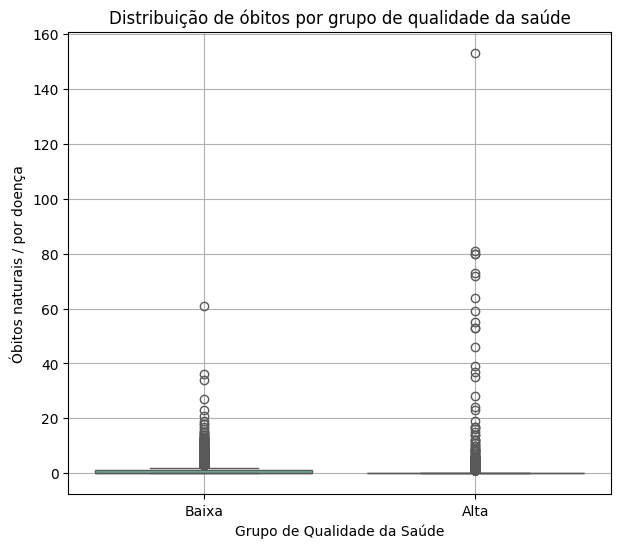

In [118]:
mediana = dfp2_plot['score_qualidade_saude'].median()
dfp2['Grupo Qualidade'] = ['Baixa' if x <= mediana else 'Alta' for x in dfp2_plot['score_qualidade_saude']]

plt.figure(figsize=(7, 6))
sns.boxplot(x='Grupo Qualidade', y='obitos_doenca', data=dfp2, palette='Set2')
plt.title('Distribuição de óbitos por grupo de qualidade da saúde')
plt.xlabel('Grupo de Qualidade da Saúde')
plt.ylabel('Óbitos naturais / por doença')
plt.grid(True)
plt.show()

**Testes de hipóteses**

Hipóteses:
H0 (Hipótese nula): Não há diferença significativa entre a média de óbitos em prisões com baixa e alta qualidade médica.

H1 (Hipótese alternativa): Há diferença significativa entre as médias de óbitos em prisões com baixa e alta qualidade médica.

In [119]:
dfp2_test = dfp2.dropna(subset=['score_qualidade_saude', 'obitos_doenca']).copy()

# Dividir grupos por mediana do índice
mediana = dfp2_test['score_qualidade_saude'].median()
grupo_baixo = dfp2_test[dfp2_test['score_qualidade_saude'] <= mediana]['obitos_doenca']
grupo_alto = dfp2_test[dfp2_test['score_qualidade_saude'] > mediana]['obitos_doenca']

# Teste t de duas amostras independentes (amostras não pareadas)
t_stat, p_val = stats.ttest_ind(grupo_baixo, grupo_alto, equal_var=False)

print("Estatística do teste t:", t_stat)
print("Valor-p:", p_val)

if p_val < 0.05:
    print("Rejeitamos a hipótese nula: há diferença significativa nos óbitos entre prisões com qualidade médica alta e baixa.")
else:
    print("Não rejeitamos a hipótese nula: não há evidência significativa de diferença entre os grupos.")

Estatística do teste t: 11.948380638336051
Valor-p: 9.603743677247455e-33
Rejeitamos a hipótese nula: há diferença significativa nos óbitos entre prisões com qualidade médica alta e baixa.


In [120]:
def intervalo_confianca(dados, nivel=0.95):
    n = len(dados)
    media = np.mean(dados)
    erro = stats.sem(dados)
    margem = erro * stats.t.ppf((1 + nivel) / 2., n-1)
    return media - margem, media + margem

# Intervalos de confiança para os dois grupos
ic_baixo = intervalo_confianca(grupo_baixo)
ic_alto = intervalo_confianca(grupo_alto)

print(f"\nIntervalo de confiança (95%) para a média de óbitos - Qualidade BAIXA: {ic_baixo}")
print(f"Intervalo de confiança (95%) para a média de óbitos - Qualidade ALTA:  {ic_alto}")


Intervalo de confiança (95%) para a média de óbitos - Qualidade BAIXA: (np.float64(0.9051677230568415), np.float64(0.9873952469801647))
Intervalo de confiança (95%) para a média de óbitos - Qualidade ALTA:  (np.float64(0.39470033949440064), np.float64(0.5304518629647136))


Foi analisada a relação entre a qualidade da saúde prisional e a quantidade de óbitos por causas naturais ou de saúde. Para isso, foi criado um score que combina infraestrutura médica e número de profissionais da saúde, normalizado pela população prisional de cada unidade.

Aplicou-se o teste de spearman, considerando como hipótese nula a inexistência de associação. O resultado de correlação de -0,206, com valor-p ≈ 0, indicou correlação negativa estatisticamente significante entre os fatores.

Com isso, observou-se que unidades prisionais com melhor estrutura e maior número de profissionais de saúde por preso tendem a registrar menos óbitos por causas naturais ou de saúde. No entanto, não é possível afirmar causalidade com certeza, pois outros fatores, como a idade média da população custodiada, não foram incluidos no estudo e podem influenciar os resultados.

## Pergunta 3

**Existe uma correlação entre a oferta de serviços de assistência social nas unidades prisionais com o percentual de presos que trabalham e/ou estudam?**



**Limpeza e estruturação dos dados**

Aqui foram selecionadas as colunas de interessa para responder a pergunta



In [121]:
# Filtragem das colunas
colunas_identificacao = [
    'ID',
    'Referência',
]

dados_filtrados3 = dados_filtrados[colunas_identificacao].copy()

# Colunas sobre a população carcerária
coluna_populacao_prisional = ['4.1 População prisional | Total']

dados_filtrados3['Populacao_Prisional'] = dados_filtrados['4.1 População prisional | Total']

total_presos_trabalham = [
    '6.1 Quantidade de pessoas privadas de liberdade em programas de laborterapia | Trabalho externo Masculino',
    '6.1 Quantidade de pessoas privadas de liberdade em programas de laborterapia | Trabalho externo Feminino',
    '6.1 Quantidade de pessoas privadas de liberdade em programas de laborterapia | Trabalho interno Masculino',
    '6.1 Quantidade de pessoas privadas de liberdade em programas de laborterapia | Trabalho interno Feminino'
]

total_presos_estudam = [
    '6.3 Quantidade de pessoas privadas de liberdade em atividade educacional | Alfabetização | Total',
    '6.3 Quantidade de pessoas privadas de liberdade em atividade educacional | Ensino Fundamental | Total',
    '6.3 Quantidade de pessoas privadas de liberdade em atividade educacional | Ensino Médio | Total',
    '6.3 Quantidade de pessoas privadas de liberdade em atividade educacional | Ensino Superior | Total',
    '6.3 Quantidade de pessoas privadas de liberdade em atividade educacional | Curso Técnico (acima de 800 horas de aula) | Total',
    '6.3 Quantidade de pessoas privadas de liberdade em atividade educacional | Curso de Formação Inicial e Continuada (Capacitação Profissional, acima de 160 horas de aula) | Total'
]

total_presos_trabalham_estudam = [
    '6.4 Quantidade de pessoas trabalhando e estudando, simultaneamente | Pessoas que trabalham e estudam | Masculino',
    '6.4 Quantidade de pessoas trabalhando e estudando, simultaneamente | Pessoas que trabalham e estudam | Feminino'
]

# Colunas sobre a infraestrutura dos presídios
colunas_modulo_saude = [
    '2.4 Módulo de saúde | Consultório médico | Quantidade',
    '2.4 Módulo de saúde | Consultório odontológico | Quantidade',
    '2.4 Módulo de saúde | Sala de coleta de material para laboratório | Quantidade',
    '2.4 Módulo de saúde | Sala de curativos, suturas, vacinas e posto de enfermagem | Quantidade',
    '2.4 Módulo de saúde | Cela de observação | Quantidade',
    '2.4 Módulo de saúde | Cela de enfermaria com solário | Quantidade',
    '2.4 Módulo de saúde | Sanitário para pacientes | Quantidade',
    '2.4 Módulo de saúde | Sanitários para equipe de saúde | Quantidade',
    '2.4 Módulo de saúde | Farmácia ou sala de estoque/ dispensação de medicamentos | Quantidade',
    '2.4 Módulo de saúde | Central de material esterilizado/ expurgo | Quantidade',
    '2.4 Módulo de saúde | Sala de lavagem e descontaminação | Quantidade',
    '2.4 Módulo de saúde | Sala de esterilização | Quantidade',
    '2.4 Módulo de saúde | Vestiário | Quantidade',
    '2.4 Módulo de saúde | Depósito de material de limpeza - DML | Quantidade',
    '2.4 Módulo de saúde | Sala de atendimento clínico multiprofissional | Quantidade',
    '2.4 Módulo de saúde | Sala de procedimentos | Quantidade',
    '2.4 Módulo de saúde | Sala de raio x | Quantidade',
    '2.4 Módulo de saúde | Laboratório de diagnóstico | Quantidade',
    '2.4 Módulo de saúde | Cela de espera | Quantidade',
    '2.4 Módulo de saúde | Solário para pacientes | Quantidade',
    '2.4 Módulo de saúde | Outro(s). Qual(is)? | Quantidade',
]

colunas_modulo_educacao = [
    '2.5 Módulo de educação | Sala de aula | Quantidade de salas',
    '2.5 Módulo de educação | Sala de informática | Quantidade de salas',
    '2.5 Módulo de educação | Sala de encontros com a sociedade/ sala de reuniões | Quantidade de salas',
    '2.5 Módulo de educação | Biblioteca | Quantidade de salas',
    '2.5 Módulo de educação | Sala de professores | Quantidade de salas',
    '2.5 Módulo de educação | Outro(s). Qual(is)? | Quantidade de salas',
]

colunas_modulo_oficinas = [
    '2.5.1 Há local específico para biblioteca?',
    '2.6 Módulo de oficinas | Sala de produção',
    '2.6 Módulo de oficinas | Sala de controle/ supervisão',
    '2.6 Módulo de oficinas | Sanitários',
    '2.6 Módulo de oficinas | Estoque',
    '2.6 Módulo de oficinas | Carga/ descarga',
    '2.6 Módulo de oficinas | Artefatos de concreto',
    '2.6 Módulo de oficinas | Blocos e tijolos',
    '2.6 Módulo de oficinas | Padaria e panificação',
    '2.6 Módulo de oficinas | Corte e costura industrial',
    '2.6 Módulo de oficinas | Artesanato',
    '2.6 Módulo de oficinas | Marcenaria',
    '2.6 Módulo de oficinas | Serralheria',
]

colunas_interesse = colunas_identificacao + coluna_populacao_prisional + colunas_modulo_saude + colunas_modulo_oficinas + colunas_modulo_educacao + total_presos_trabalham + total_presos_estudam + total_presos_trabalham_estudam

As perguntas dos módulos 2.5.1 e 2.6 foram respondidas com 'Sim' ou 'Não' a fim de indicar a presença ou ausência das respectivas oficinas nas unidades prisionais.
Como a intenção aqui era fazer uma análise quantitativa e somar a quantidade de módulos em cada unidade, as respostas nominais foram transformadas em númericas para que isso fosse possível ('Sim' = 1  e 'Não' = 0).

Ter o valor = 1 significará, portanto, que existe pelo menos um módulo dessa oficina no presídio e esse valor será somado a quantidade total de módulos da respectiva unidade prisional.

In [122]:
# Atualização dos dados
dados_3 = dados_filtrados[colunas_interesse].replace({
    np.nan: '0.0',
    'Sim': '1.0',
    'Não': '0.0'
}, regex=True)

# Renomeação da coluna 4.1
dados_3 = dados_3.rename(columns={'4.1 População prisional | Total': 'Populacao_Prisional'})

# Soma das colunas agrupadas em três módulos
dados_filtrados3['Total_Modulo_Saude'] = dados_3[colunas_modulo_saude].astype(float).sum(axis=1)
dados_filtrados3['Total_Modulo_Educacao'] = dados_3[colunas_modulo_educacao].astype(float).sum(axis=1)
dados_filtrados3['Total_Modulo_Oficinas'] = dados_3[colunas_modulo_oficinas].astype(float).sum(axis=1)

dados_filtrados3['Total_Presos_Empregados'] = dados_3[total_presos_trabalham].astype(float).sum(axis=1)
dados_filtrados3['Total_Presos_Estudantes'] = dados_3[total_presos_estudam].astype(float).sum(axis=1)
dados_filtrados3['Total_Presos_Empregados_Estudantes'] = dados_3[total_presos_trabalham_estudam].astype(float).sum(axis=1)

# Cálculo da taxa ocupacional em cada presídio
dados_filtrados3['Taxa_Ocupacao'] = ((dados_filtrados3['Total_Presos_Empregados'] + dados_filtrados3['Total_Presos_Estudantes'] + dados_filtrados3['Total_Presos_Empregados_Estudantes']) / dados_filtrados3['Populacao_Prisional'].astype(float)) * 100

colunas_filtradas = ['ID',
  'Referência',
  'Total_Modulo_Saude',
  'Total_Modulo_Educacao',
  'Total_Modulo_Oficinas',
  'Populacao_Prisional',
  'Total_Presos_Empregados',
  'Total_Presos_Estudantes',
  'Total_Presos_Empregados_Estudantes',
  'Taxa_Ocupacao']

dados_filtrados3 = dados_filtrados3[colunas_filtradas]

dados_filtrados3.head(10)

,ID,Referência,Total_Modulo_Saude,Total_Modulo_Educacao,Total_Modulo_Oficinas,Populacao_Prisional,Total_Presos_Empregados,Total_Presos_Estudantes,Total_Presos_Empregados_Estudantes,Taxa_Ocupacao
0,4410.0,2024/2,0.0,0.0,0.0,199,0.0,0.0,9.0,4.522613
1,5570.0,2024/2,0.0,0.0,0.0,173,162.0,0.0,0.0,93.641618
2,3581.0,2024/2,0.0,0.0,0.0,327,0.0,0.0,0.0,0.000000
3,3579.0,2024/2,0.0,0.0,0.0,350,0.0,0.0,0.0,0.000000
4,1841.0,2024/2,0.0,0.0,0.0,1670,0.0,0.0,0.0,0.000000
5,31.0,2024/2,25.0,0.0,0.0,1724,1409.0,248.0,0.0,96.113689
6,35.0,2024/2,7.0,5.0,6.0,169,161.0,128.0,0.0,171.005917
7,34.0,2024/2,0.0,9.0,1.0,1159,1059.0,259.0,2.0,113.891286
8,33.0,2024/2,0.0,2.0,1.0,86,0.0,0.0,0.0,0.000000
9,39.0,2024/2,0.0,0.0,0.0,25,0.0,0.0,0.0,0.000000


In [123]:
print(len(dados_filtrados3[dados_filtrados3['Taxa_Ocupacao'] > 100]))


3782


Nota-se, com o resultado acima, a presença de registros com valores de taxa de ocupação que superam a lotação máxima do presídio, o que é um forte indicativo de que há presídios com superlotação. Pensando por essa linha de raciocínio, foi decidido não tratar esses valores como outliers e preservá-los na análise.





*   Estatísticas



In [124]:
dados_filtrados3.describe()

,ID,Total_Modulo_Saude,Total_Modulo_Educacao,Total_Modulo_Oficinas,Populacao_Prisional,Total_Presos_Empregados,Total_Presos_Estudantes,Total_Presos_Empregados_Estudantes,Taxa_Ocupacao
count,25738.000000,25738.000000,25738.000000,25738.000000,25738.000000,25738.000000,25738.000000,25738.000000,25737.000000
mean,1382.663727,7.828619,3.565662,2.064574,519.664970,93.984614,71.235566,13.967946,59.214313
std,1391.369355,11.078454,4.372198,2.644001,1107.806943,169.346838,155.234939,55.228803,602.260100
min,31.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,545.000000,0.000000,0.000000,0.000000,80.000000,3.000000,0.000000,0.000000,6.611570
50%,986.000000,4.000000,2.000000,1.000000,192.000000,34.000000,16.000000,0.000000,29.640719
75%,1404.000000,12.000000,6.000000,3.000000,640.000000,105.000000,80.000000,5.000000,67.567568
max,7369.000000,218.000000,183.000000,13.000000,42535.000000,2604.000000,3683.000000,1749.000000,68200.000000


O gráfico abaixo apresenta a evolução da média os módulos de interesse ao longo dos semestres. Para isso, utilizou-se o método lineplot() da biblioteca Seaborn, que plota a média dos valores de cada categoria em função do tempo e inclui intervalos de confiança padronizados de 95%.



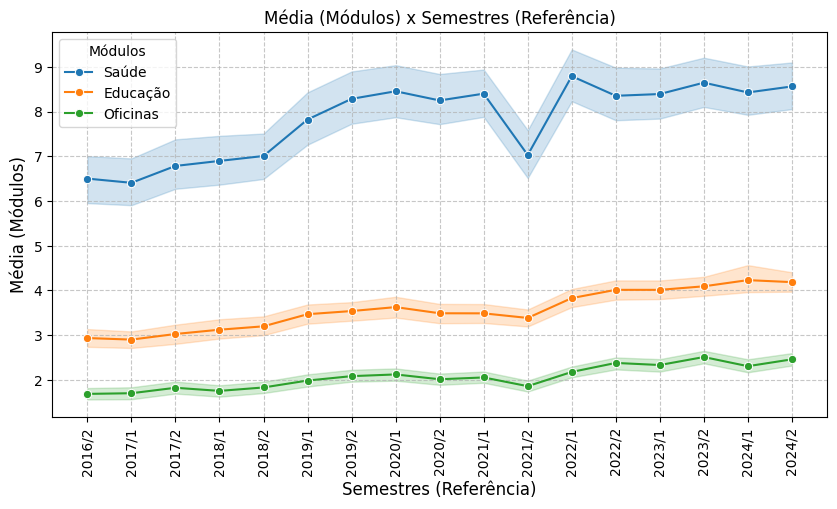

In [125]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 5))

# Inverter os eixos
dados_filtrados3 = dados_filtrados3.iloc[::-1].reset_index(drop=True)

sns.lineplot(x=dados_filtrados3['Referência'], y=dados_filtrados3['Total_Modulo_Saude'], marker='o', label='Saúde')
sns.lineplot(x=dados_filtrados3['Referência'], y=dados_filtrados3['Total_Modulo_Educacao'], marker='o', label='Educação')
sns.lineplot(x=dados_filtrados3['Referência'], y=dados_filtrados3['Total_Modulo_Oficinas'], marker='o', label='Oficinas')

plt.title('Média (Módulos) x Semestres (Referência)', fontsize=12)
plt.xlabel('Semestres (Referência)', fontsize=12)
plt.ylabel('Média (Módulos)', fontsize=12)

plt.xticks(rotation=90, ha='center', fontsize=10)

plt.legend(title='Módulos', fontsize=10, title_fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)

plt.show()

**Testes de hipóteses**

H₀ (hipótese nula): Não existe correlação entre a oferta de serviços de assistência social e o percentual de presos que trabalham/estudam.

H₁ (hipótese alternativa): Existe correlação entre a oferta de serviços de assistência social e o percentual de presos que trabalham/estudam.

In [126]:
dados_percentuais = pd.DataFrame()

# Calcular o percentual de atividade
dados_percentuais['Percentual_Atividade'] = (
    dados_filtrados3['Total_Presos_Empregados_Estudantes'] / dados_filtrados3['Populacao_Prisional']
) * 100

# Calcular a oferta de assistência social como média dos módulos
dados_percentuais['Oferta_Assistencia_Social'] = dados_filtrados3[['Total_Modulo_Saude', 'Total_Modulo_Educacao', 'Total_Modulo_Oficinas']].mean(axis=1)

# Verificar se há linhas totalmente nulas
print(dados_percentuais[['Oferta_Assistencia_Social', 'Percentual_Atividade']].isnull().sum())


Oferta_Assistencia_Social    0
Percentual_Atividade         1
dtype: int64


In [127]:
# Remoção de linhas totalmente nulas
dados_limpos = dados_percentuais.dropna(subset=['Oferta_Assistencia_Social', 'Percentual_Atividade'])

In [128]:
dados_limpos[['Oferta_Assistencia_Social', 'Percentual_Atividade']].describe()


,Oferta_Assistencia_Social,Percentual_Atividade
count,25737.000000,25737.000000
mean,4.486459,5.096329
std,5.054739,31.091503
min,0.000000,0.000000
25%,0.666667,0.000000
50%,3.000000,0.000000
75%,7.000000,2.222222
max,75.666667,4000.000000


In [129]:
from scipy.stats import spearmanr

resultados_correlacao = []

for _ in range(1000):
    resultado_3 = dados_limpos.sample(frac=1, replace=True)
    corr, p_val = spearmanr(resultado_3['Oferta_Assistencia_Social'], resultado_3['Percentual_Atividade'])
    resultados_correlacao.append(corr)

# Intervalo de confiança de 95%
limite_inferior = np.percentile(resultados_correlacao, 2.5)
limite_superior = np.percentile(resultados_correlacao, 97.5)

print("Coeficiente de correlação de Pearson:", corr)
print(f"Intervalo de confiança 95%: [{limite_inferior:.3f}, {limite_superior:.3f}]")
print("Valor-p:", p_val)

if p_val < 0.05:
    print("Rejeitamos H0: há correlação significativa.")
else:
    print("Não rejeitamos H0: não há evidência de correlação significativa.")

Coeficiente de correlação de Pearson: 0.22813077967125894
Intervalo de confiança 95%: [0.222, 0.244]
Valor-p: 4.5933934367928846e-301
Rejeitamos H0: há correlação significativa.


Com finalidade de investir uma correlação existente entre a oferta de serviços de assistência social nas unidades prisionais e a proporção de detentos envolvidos em atividades de trabalho e/ou estudo, criou-se variável que representa a média da disponibilidade dos módulos ofertados em cada unidade prisional e calculou-se o percentual de presos participantes dessas atividades em relação à população total de cada unidade.

Para avaliar essa relação, utilizou-se Spearman, tendo como hipótese nula a ausência de associação entre as variáveis analisadas.

O teste apontou uma correlação positiva de, aproximadamente, 0,23, com valor-p muito próximo de zero. Apesar de fraca, há uma relação estatisticamente significativa entre a oferta de serviços e a participação dos presos em atividades laborais e/ou educacionais.

Os dados sugerem, portanto, que unidades com maior estrutura de serviços assistenciais tendem a apresentar proporções mais altas de presos trabalhando ou estudando.

## Pergunta 4
**Existe uma correlação entre o tipo de crime pelo qual os detentos foram condenados e a incidência de óbitos prisionais de natureza criminal?**


**Limpeza e estruturação dos dados**

Inicialmente, selecionamos as variáveis relevantes: número de detentos por tipo penal, total de óbitos criminais por unidade e população prisional total. Para garantir a integridade, espaços em branco foram convertidos para valores ausentes (NaN).

In [130]:
coluna_populacao_prisional = ['4.1 População prisional | Total']

# Coluna com a variável-alvo: óbitos criminais
mortalidade_criminal = [
    '6.8 Mortalidade no Sistema Prisional (total do período) | Óbitos criminais | Total'
]

# Palavra-chave para identificar colunas com incidência de crimes
crimes = [
    '5.14 Quantidade de incidências por tipo penal'
]

# Seleciona apenas as colunas de crimes totais por tipo penal
colunas_crimes = [
    col for col in dados_filtrados.columns
    if '5.14' in col and 'Total' in col and any(tipo in col for tipo in crimes)
]

# Seleciona apenas as colunas relevantes: crimes, óbitos e população prisional
colunas_selecionadas = colunas_crimes + mortalidade_criminal + coluna_populacao_prisional
dados_filtrados4 = dados_filtrados[colunas_selecionadas]

# Substitui espaços em branco por NaN para normalizar os dados ausentes
dados_filtrados4 = dados_filtrados4.replace(r'^\s*$', np.nan, regex=True)

In [131]:
# Renomeação das colunas
dados_filtrados4_renomeados = dados_filtrados4.copy()
dados_filtrados4_renomeados.columns = [
    'Populacao_Prisional',
    'Pessoa_Homicidio_Simples',
    'Pessoa_Homicidio_Culposo',
    'Pessoa_Homicidio_Qualificado',
    'Pessoa_Aborto',
    'Pessoa_Lesao_Corporal',
    'Pessoa_Violencia_Domestica',
    'Pessoa_Sequestro_Carcere',
    'Pessoa_Outros_122_154A',

    'Patrimonio_Furto_Simples',
    'Patrimonio_Furto_Qualificado',
    'Patrimonio_Roubo_Simples',
    'Patrimonio_Roubo_Qualificado',
    'Patrimonio_Latrocinio',
    'Patrimonio_Extorsao',
    'Patrimonio_Extorsao_Sequestro',
    'Patrimonio_Apropriacao_Indebita',
    'Patrimonio_Apropriacao_Previdenciaria',
    'Patrimonio_Estelionato',
    'Patrimonio_Receptacao',
    'Patrimonio_Receptacao_Qualificada',
    'Patrimonio_Outros_156_179',

    'Sexual_Estupro',
    'Sexual_Atentado_Violento_Pudor',
    'Sexual_Estupro_Vulneravel',
    'Sexual_Corrupcao_Menores',
    'Sexual_Trafico_Internacional',
    'Sexual_Trafico_Interno',
    'Sexual_Outros',

    'PazPublica_Quadrilha_Bando',

    'FePublica_Moeda_Falsa',
    'FePublica_Falsificacao_Documentos',
    'FePublica_Falsidade_Ideologica',
    'FePublica_Uso_Documento_Falso',

    'AdmPublica_Peculato',
    'AdmPublica_Concussao_Exacao',
    'AdmPublica_Corrupcao_Passiva',

    'Particular_Corrupcao_Ativa',
    'Particular_Contrabando_Descaminho',

    'Drogas_Trafico',
    'Drogas_Associacao_Trafico',
    'Drogas_Trafico_Internacional',

    'Armas_Porte_Ilegal_Permitido',
    'Armas_Disparo',
    'Armas_Porte_Ilegal_Restrito',
    'Armas_Comercio_Ilegal',
    'Armas_Trafico_Internacional',

    'Transito_Homicidio_Culposo',

    'LegEspecifica_Outros_303_312',
    'LegEspecifica_ECA_Lei_8.069',
    'LegEspecifica_Genocidio',
    'LegEspecifica_Tortura',
    'LegEspecifica_MeioAmbiente',
    'LegEspecifica_ECA_Lei_869',

    'Obitos_Criminais_Total'
]

In [132]:
dados_filtrados4_renomeados.head(15)

,Populacao_Prisional,Pessoa_Homicidio_Simples,Pessoa_Homicidio_Culposo,Pessoa_Homicidio_Qualificado,Pessoa_Aborto,Pessoa_Lesao_Corporal,Pessoa_Violencia_Domestica,Pessoa_Sequestro_Carcere,Pessoa_Outros_122_154A,Patrimonio_Furto_Simples,...,Armas_Comercio_Ilegal,Armas_Trafico_Internacional,Transito_Homicidio_Culposo,LegEspecifica_Outros_303_312,LegEspecifica_ECA_Lei_8.069,LegEspecifica_Genocidio,LegEspecifica_Tortura,LegEspecifica_MeioAmbiente,LegEspecifica_ECA_Lei_869,Obitos_Criminais_Total
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,199
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,173
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,327
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,350
4,109.0,0.0,180.0,0.0,3.0,4.0,0.0,36.0,70.0,70.0,...,1.0,2.0,5.0,30.0,0.0,5.0,6.0,NaN,5.0,1670
5,60.0,2.0,200.0,NaN,14.0,NaN,NaN,NaN,31.0,48.0,...,NaN,NaN,1.0,3.0,NaN,7.0,NaN,NaN,0.0,1724
6,4.0,0.0,26.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,169
7,39.0,NaN,188.0,NaN,7.0,NaN,7.0,NaN,NaN,NaN,...,NaN,2.0,NaN,18.0,NaN,3.0,NaN,NaN,0.0,1159
8,12.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,5.0,0.0,...,NaN,NaN,7.0,NaN,NaN,NaN,NaN,NaN,0.0,86
9,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,3.0,2.0,...,0.0,NaN,NaN,0.0,NaN,0.0,0.0,NaN,0.0,25


In [133]:
# Calcula a porcentagem de valores NaN em cada coluna
nan_percent = dados_filtrados4_renomeados.isna().mean()

# Exibe as colunas ordenadas pela porcentagem de NaNs de forma descrescente
nan_percent.sort_values(ascending=False)

LegEspecifica_MeioAmbiente               0.827531
LegEspecifica_Outros_303_312             0.782850
LegEspecifica_ECA_Lei_8.069              0.727290
AdmPublica_Peculato                      0.714547
Sexual_Trafico_Internacional             0.706698
AdmPublica_Concussao_Exacao              0.706387
Sexual_Corrupcao_Menores                 0.703979
Particular_Corrupcao_Ativa               0.703357
Armas_Comercio_Ilegal                    0.697140
Armas_Trafico_Internacional              0.694887
LegEspecifica_Tortura                    0.694343
Armas_Porte_Ilegal_Restrito              0.690730
Patrimonio_Apropriacao_Indebita          0.689098
Pessoa_Homicidio_Qualificado             0.679307
LegEspecifica_Genocidio                  0.675694
AdmPublica_Corrupcao_Passiva             0.672002
PazPublica_Quadrilha_Bando               0.668039
FePublica_Uso_Documento_Falso            0.661162
FePublica_Moeda_Falsa                    0.658909
Sexual_Estupro_Vulneravel                0.656733


In [134]:
# Mantém apenas colunas com até 70% de NaN
colunas_validas = nan_percent[nan_percent <= 0.7].index
dados_filtrados4_renomeados = dados_filtrados4_renomeados[colunas_validas]

# Atualiza a lista de colunas de crimes com as que permaneceram
colunas_crimes = [col for col in dados_filtrados4_renomeados.columns if (col != 'Obitos_Criminais_Total' and col != 'Populacao_Prisional')]

# Atualiza a lista com a coluna de óbitos após a renomeação
mortalidade_criminal = ['Obitos_Criminais_Total']


In [135]:
print(dados_filtrados4_renomeados.shape)
print("Qtd de linhas completamente nulas:", (dados_filtrados4_renomeados.isna().sum(axis=1) == 46).sum())

(25738, 47)
Qtd de linhas completamente nulas: 4834


In [136]:
# Remove linhas completamente nulas (com NaN)
dados_filtrados4_renomeados = dados_filtrados4_renomeados.dropna(how='all')

# Remove linhas onde todos os crimes são NaN
dados_filtrados4_renomeados = dados_filtrados4_renomeados.dropna(
    subset=colunas_crimes, how='all'
)

dados_filtrados4_renomeados.shape

(20898, 47)

As variáveis relacionadas ao tipo de crime são discretas e representam o número de registros por categoria em cada unidade prisional. Como que a presença de valores ausentes sugere a ausência do crime em questão, devido há alta quantidade de dados NaN em cada coluna utilizada,  optamos por preencher esses valores com zero para evitar distorções estatísticas.

In [137]:
# Substitui NaNs restantes por 0.0
dados_filtrados4_renomeados = dados_filtrados4_renomeados.fillna(0.0)

In [138]:
# Mantém apenas unidades com população prisional > 0 (evita divisão por zero)
dados_filtrados4_renomeados = dados_filtrados4_renomeados[dados_filtrados4_renomeados['Populacao_Prisional'] > 0]

# Cria colunas com proporção de cada crime por preso
for col in colunas_crimes:
    dados_filtrados4_renomeados[f'{col}_por_preso'] = (
        dados_filtrados4_renomeados[col] / dados_filtrados4_renomeados['Populacao_Prisional']
    )

# Cria a coluna com a proporção de óbitos criminais por preso
dados_filtrados4_renomeados['Obitos_Criminais_Total_por_preso'] = (
    dados_filtrados4_renomeados['Obitos_Criminais_Total'] / dados_filtrados4_renomeados['Populacao_Prisional']
)

Para fazer a análise por grupo de crimes em vez de cada tipo penal isoladamente, é necessário somar os valores de cada grupo e criar novas colunas com esses totais proporcionais.

In [139]:
# Grupos de crimes
grupos_crimes = {
    'Pessoa': [
        'Pessoa_Homicidio_Simples', 'Pessoa_Homicidio_Culposo', 'Pessoa_Homicidio_Qualificado',
        'Pessoa_Aborto', 'Pessoa_Lesao_Corporal', 'Pessoa_Violencia_Domestica',
        'Pessoa_Sequestro_Carcere', 'Pessoa_Outros_122_154A'
    ],
    'Patrimonio': [
        'Patrimonio_Furto_Simples', 'Patrimonio_Furto_Qualificado', 'Patrimonio_Roubo_Simples',
        'Patrimonio_Roubo_Qualificado', 'Patrimonio_Latrocinio', 'Patrimonio_Extorsao',
        'Patrimonio_Extorsao_Sequestro', 'Patrimonio_Apropriacao_Indebita',
        'Patrimonio_Apropriacao_Previdenciaria', 'Patrimonio_Estelionato',
        'Patrimonio_Receptacao', 'Patrimonio_Receptacao_Qualificada', 'Patrimonio_Outros_156_179'
    ],
    'Sexual': [
        'Sexual_Estupro', 'Sexual_Atentado_Violento_Pudor', 'Sexual_Estupro_Vulneravel',
        'Sexual_Corrupcao_Menores', 'Sexual_Trafico_Internacional',
        'Sexual_Trafico_Interno', 'Sexual_Outros'
    ],
    'PazPublica': [
        'PazPublica_Quadrilha_Bando'
    ],
    'FePublica': [
        'FePublica_Moeda_Falsa',
        'FePublica_Falsificacao_Documentos',
        'FePublica_Falsidade_Ideologica',
        'FePublica_Uso_Documento_Falso'
    ],
    'AdmPublica': [
        'AdmPublica_Peculato',
        'AdmPublica_Concussao_Exacao',
        'AdmPublica_Corrupcao_Passiva'
    ],
    'AdmPublicaParticular': [
        'Particular_Corrupcao_Ativa',
        'Particular_Contrabando_Descaminho'
    ],
    'Drogas': [
        'Drogas_Trafico',
        'Drogas_Associacao_Trafico',
        'Drogas_Trafico_Internacional'
    ],
    'Armas': [
        'Armas_Porte_Ilegal_Permitido',
        'Armas_Disparo',
        'Armas_Porte_Ilegal_Restrito',
        'Armas_Comercio_Ilegal',
        'Armas_Trafico_Internacional'
    ],
    'Transito': [
        'Transito_Homicidio_Culposo'
    ],
    'LegEspecifica/Outros': [
        'LegEspecifica_Outros_303_312',
        'LegEspecifica_ECA_Lei_8.069',
        'LegEspecifica_Genocidio',
        'LegEspecifica_Tortura',
        'LegEspecifica_MeioAmbiente',
        'LegEspecifica_ECA_Lei_869'
    ]
}

# Criar colunas agregadas por grupo (soma proporcional por preso)
for grupo, colunas in grupos_crimes.items():
    colunas_proporcionais = [col + '_por_preso' for col in colunas if col + '_por_preso' in dados_filtrados4_renomeados.columns]
    dados_filtrados4_renomeados[grupo + '_Total_por_preso'] = dados_filtrados4_renomeados[colunas_proporcionais].sum(axis=1)


vou alterar

In [ ]:
# Lista das colunas agregadas por grupo
#colunas_grupos_total = [grupo + '_Total_por_preso' for grupo in grupos_crimes]

# Adiciona a variável-alvo
#colunas_grupos_total.append('Obitos_Criminais_Total_por_preso')

# Calcula a matriz de correlação
#matriz_correlacao = dados_filtrados4_renomeados[colunas_grupos_total].corr()

# Exibe a correlação da variável-alvo com cada grupo
#correlacoes_com_obitos = matriz_correlacao['Obitos_Criminais_Total_por_preso'].drop('Obitos_Criminais_Total_por_preso')
#print(correlacoes_com_obitos)

#plt.figure(figsize=(10, 6))
#sns.heatmap(matriz_correlacao, annot=True, cmap='coolwarm', center=0)
#plt.title('Correlação entre grupos de crimes e óbitos prisionais (por preso)')
#plt.tight_layout()
#plt.show()



**Estatísticas**

In [141]:
# Seleciona todas as colunas que representam proporções por preso
colunas_proporcionais_geral = [
    col for col in dados_filtrados4_renomeados.columns
    if col.endswith('_por_preso')
]
""
# Gera estatísticas descritivas dessas colunas
estatisticas = dados_filtrados4_renomeados[colunas_proporcionais_geral].describe()
estatisticas

       Pessoa_Homicidio_Simples_por_preso  Pessoa_Homicidio_Culposo_por_preso  \
count                        13930.000000                        13930.000000   
mean                             0.159486                            3.025951   
std                              1.020757                           11.676003   
min                              0.000000                            0.000000   
25%                              0.000000                            0.166667   
50%                              0.000000                            1.000000   
75%                              0.000000                            3.000000   
max                             54.000000                          744.057143   

       Pessoa_Homicidio_Qualificado_por_preso  Pessoa_Aborto_por_preso  \
count                            13930.000000             13930.000000   
mean                                 0.010468                 0.381062   
std                                  0.180345   

**Distribuição dos grupos penais proporcionais (por preso)**   
Para entender a distribuição global dos grupos penais no sistema prisional, utilizamos um treemap, que representa a composição proporcional acumulada por preso de cada grupo de crime. Cada retângulo é dimensionado de acordo com a soma das proporções de um grupo em todos os presídios.
Essa visualização permite identificar quais grupos têm maior peso no conjunto, possibilitando uma leitura comparativa entre eles.

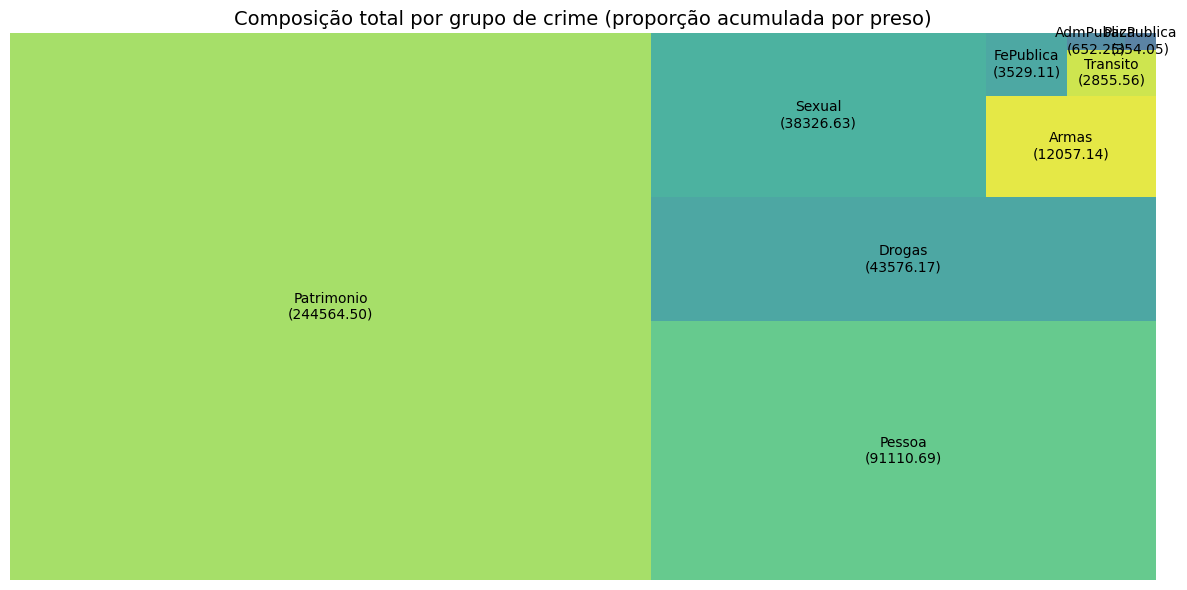

In [150]:
# Calcular o total acumulado por grupo (somando proporções de todos os presídios)
soma_grupos = {
    grupo: dados_filtrados4_renomeados[grupo + '_Total_por_preso'].sum()
    for grupo in grupos_crimes.keys()
    if grupo + '_Total_por_preso' in dados_filtrados4_renomeados.columns
}

# Ordenar por valor (para deixar a visualização mais intuitiva)
soma_grupos_ordenado = dict(sorted(soma_grupos.items(), key=lambda item: item[1], reverse=True))

# Dados para o gráfico
labels = [f"{k}\n({v:.2f})" for k, v in soma_grupos_ordenado.items()]
sizes = list(soma_grupos_ordenado.values())

plt.figure(figsize=(12, 6))
squarify.plot(sizes=sizes, label=labels, alpha=0.8)
plt.title("Composição total por grupo de crime (proporção acumulada por preso)", fontsize=14)
plt.axis('off')
plt.tight_layout()
plt.show()

**Distribuição dos óbitos criminais proporcionais à população prisional**

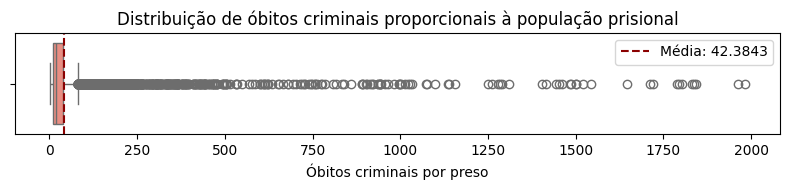

In [143]:
# Boxplot dos óbitos criminais por preso
plt.figure(figsize=(8, 2))
sns.boxplot(
    data=dados_filtrados4_renomeados,
    x='Obitos_Criminais_Total_por_preso',
    color='salmon'
)
media_obitos = dados_filtrados4_renomeados['Obitos_Criminais_Total_por_preso'].mean()
plt.axvline(media_obitos, color='darkred', linestyle='--', label=f'Média: {media_obitos:.4f}')
plt.title('Distribuição de óbitos criminais proporcionais à população prisional')
plt.xlabel('Óbitos criminais por preso')
plt.legend()
plt.tight_layout()
plt.show()

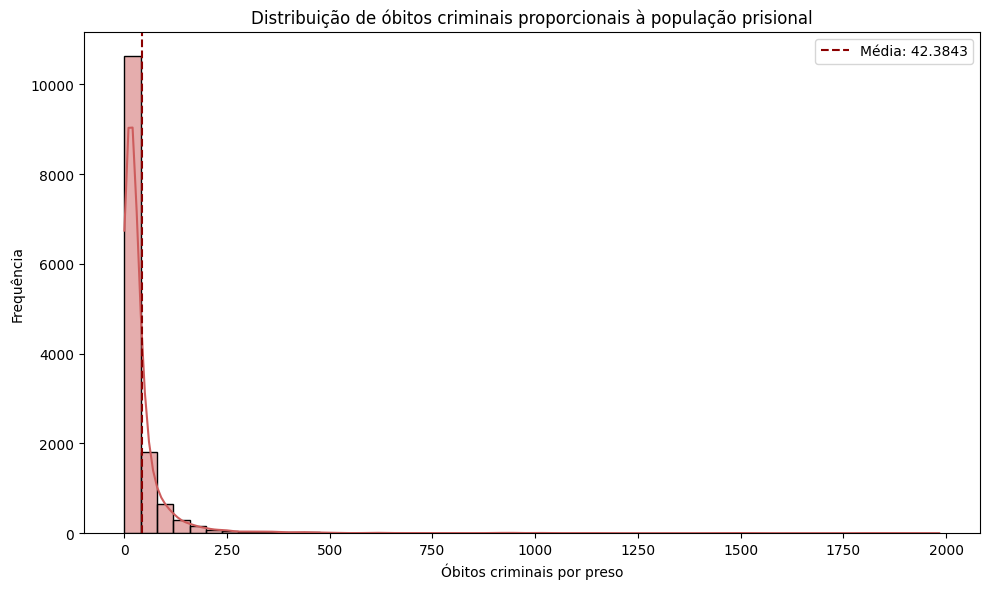

In [144]:
# Histograma com KDE para óbitos por preso
plt.figure(figsize=(10, 6))
sns.histplot(
    data=dados_filtrados4_renomeados,
    x='Obitos_Criminais_Total_por_preso',
    kde=True,
    color='indianred',
    bins=50
)
plt.axvline(media_obitos, color='darkred', linestyle='--', label=f'Média: {media_obitos:.4f}')
plt.title('Distribuição de óbitos criminais proporcionais à população prisional')
plt.xlabel('Óbitos criminais por preso')
plt.ylabel('Frequência')
plt.legend()
plt.tight_layout()
plt.show()

Como mostram as figuras acima, a maior parte das observações está concentrada em valores baixos, enquanto há uma cauda longa à direita, o que indica a presença de outliers. Logo a distribuição é assimetricamente positiva.

- Correlações entre crimes e óbitos criminais

Para investigar a relação entre os tipos de crime pelos quais os detentos foram condenados e a incidência de óbitos de natureza criminal, optou-se pelo uso do coeficiente de Spearman dado que as variáveis em análise (proporções de presos por crime e óbitos criminais por preso) não seguem distribuição normal.

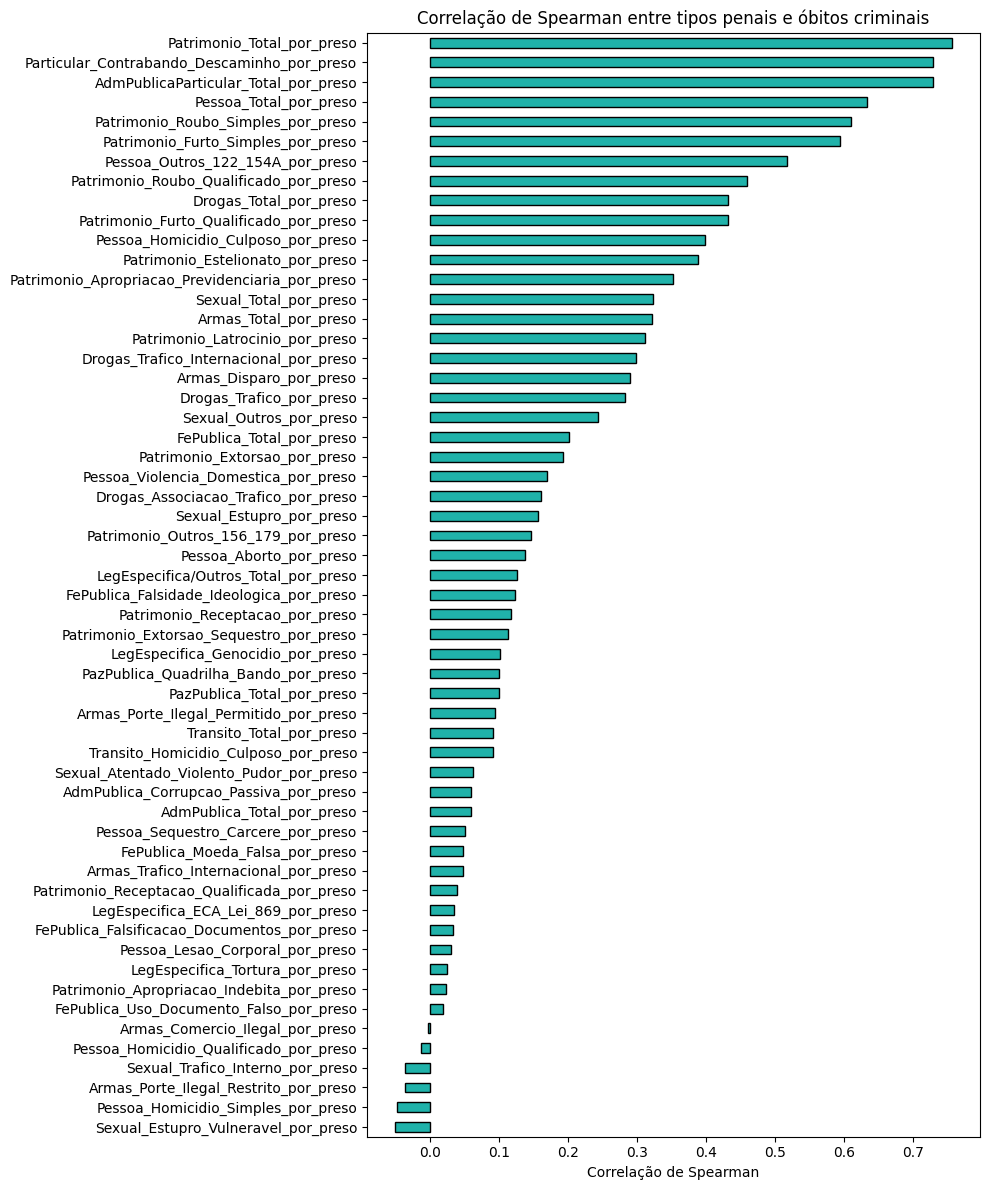

In [145]:
# Lista de colunas com dados proporcionais de crimes, removendo a coluna relacionada ao óbito criminais por preso
colunas_proporcionais = [
    col for col in colunas_proporcionais
    if col != 'Obitos_Criminais_Total_por_preso'
]

# Calcula correlações de Spearman
spearman_corr = dados_filtrados4_renomeados[colunas_proporcionais + ['Obitos_Criminais_Total_por_preso']].corr(method='spearman')

# Seleciona apenas a coluna de correlação com os óbitos criminaise
spearman_obitos = spearman_corr.loc[colunas_proporcionais, 'Obitos_Criminais_Total_por_preso'].sort_values(ascending=False)

plt.figure(figsize=(10, 12))
spearman_obitos.plot(kind='barh', color='lightseagreen', edgecolor='black')
plt.xlabel('Correlação de Spearman')
plt.title('Correlação de Spearman entre tipos penais e óbitos criminais')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

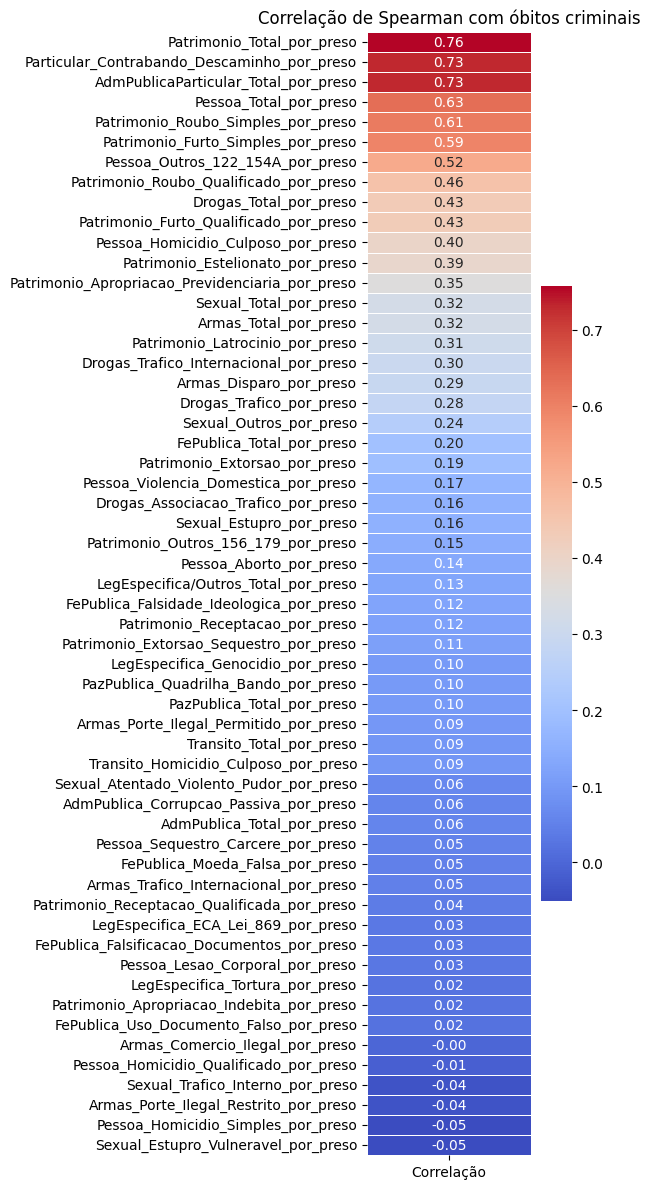

In [146]:
plt.figure(figsize=(6, 12))

# Criação de um heatmap para representar as correlações de Spearman
sns.heatmap(spearman_obitos.to_frame(),
            cmap='coolwarm',
            annot=True,
            fmt=".2f",
            linewidths=0.5,
            cbar=True,
            xticklabels=['Correlação'])

plt.title('Correlação de Spearman com óbitos criminais')
plt.tight_layout()
plt.show()

A análise indicou que certos crimes apresentam associação mais forte com a ocorrência de óbitos criminais no sistema prisional.

**Testes de hipóteses**

Para cada tipo de crime C, testamos a seguinte hipótese:
- Hipótese nula (H0): Não existe correlação entre a proporção de presos por crime C e a proporção de óbitos criminais. H0: p = 0
- Hipótese alternativa (H1): Existe correlação entre a proporção de presos por crime C e a proporção de óbitos criminais. H1: p != 0


Como a distribuição dos dados não é normal, optou-se por usar coeficiente de correlação de Spearman para os testes de hipótese. Utilizou-se um nível de significância α=0,05.

In [147]:
# Calcula intervalo de confiança para a correlação de Spearman usando bootstrapping
def intervalo_confianca_spearman_bootstrap(vetor_crime, vetor_obitos, num_reamostragens=1000, nivel_significancia=0.05, semente=None):
    gerador_aleatorio = np.random.default_rng(seed=semente)
    lista_rho = []
    tamanho_amostra = len(vetor_crime)

    # Reamostra os dados com reposição e calcula a correlação para cada amostra
    for _ in range(num_reamostragens):
        indices_reamostrados = gerador_aleatorio.choice(tamanho_amostra, size=tamanho_amostra, replace=True)
        rho, _ = stats.spearmanr(vetor_crime[indices_reamostrados], vetor_obitos[indices_reamostrados])
        lista_rho.append(rho)

    # Calcula os limites inferior e superior do intervalo de confiança
    limite_inferior = np.percentile(lista_rho, 100 * (nivel_significancia / 2))
    limite_superior = np.percentile(lista_rho, 100 * (1 - nivel_significancia / 2))
    return limite_inferior, limite_superior

resultados_correlacao = []

# Para cada tipo de crime, calcula a correlação de Spearman e o intervalo de confiança
for coluna_crime in colunas_proporcionais:
    vetor_proporcao_crime = dados_filtrados4_renomeados[coluna_crime].values
    vetor_obitos_por_preso = dados_filtrados4_renomeados['Obitos_Criminais_Total_por_preso'].values

    # Correlação e valor-p
    coef_spearman, valor_p = stats.spearmanr(vetor_proporcao_crime, vetor_obitos_por_preso)

    # Intervalo de confiança por bootstrapping
    limite_inferior, limite_superior = intervalo_confianca_spearman_bootstrap(
        vetor_proporcao_crime,
        vetor_obitos_por_preso,
        num_reamostragens=1000,
        nivel_significancia=0.05
    )

    decisao_hipotese = 'Rejeitamos H0' if valor_p < 0.05 else 'Não rejeitamos H0'

    resultados_correlacao.append({
        'Tipo de Crime': coluna_crime,
        'Correlação de Spearman (ρ)': coef_spearman,
        'Valor-p': valor_p,
        'IC Inferior (95%)': limite_inferior,
        'IC Superior (95%)': limite_superior,
        'Decisão': decisao_hipotese
    })

# Converte os resultados em DataFrame e ordena do maior para o menor coeficiente de correlação
df_resultados_correlacao = pd.DataFrame(resultados_correlacao).sort_values(
    by='Correlação de Spearman (ρ)', ascending=False
)

print(df_resultados_correlacao)

                                      Tipo de Crime  \
46                       Patrimonio_Total_por_preso   
32      Particular_Contrabando_Descaminho_por_preso   
51             AdmPublicaParticular_Total_por_preso   
45                           Pessoa_Total_por_preso   
10               Patrimonio_Roubo_Simples_por_preso   
8                Patrimonio_Furto_Simples_por_preso   
7                  Pessoa_Outros_122_154A_por_preso   
11           Patrimonio_Roubo_Qualificado_por_preso   
52                           Drogas_Total_por_preso   
9            Patrimonio_Furto_Qualificado_por_preso   
1                Pessoa_Homicidio_Culposo_por_preso   
17                 Patrimonio_Estelionato_por_preso   
16  Patrimonio_Apropriacao_Previdenciaria_por_preso   
47                           Sexual_Total_por_preso   
53                            Armas_Total_por_preso   
12                  Patrimonio_Latrocinio_por_preso   
35           Drogas_Trafico_Internacional_por_preso   
37        

Para investigar se existe uma correlação entre o tipo de crime e a incidência de óbitos prisionais criminais foram analisados os dados relacionados e aplicados testes de hipótese com o coeficiente de correlação de Spearman, juntamente com o cálculo de intervalos de confiança por bootstrapping. Os testes foram realizados individualmente para cada categoria de crime, considerando como hipótese nula a ausência de correlação entre a proporção de presos por crime e a taxa de óbitos criminais, e como hipótese alternativa a existência de uma correlação significativa.

Em grande parte dos crimes analisados, os valores de p encontrados foram menores que o nível de significância utilizado (α = 0,05), o que permitiu rejeitar a hipótese nula. Isso indica a presença de uma associação estatística entre o tipo de crime e a ocorrência de mortes por causas criminais no sistema prisional. Crimes como contrabando/descaminho, roubo simples e furto simples apresentaram coeficientes de correlação (rho) acima de 0,59, sugerindo que os detentos condenados por esses delitos podem estar mais expostos a situações de violência ou vulnerabilidade nas unidades prisionais. Por outro lado, em crimes como comércio ilegal de armas e homicídio qualificado não foi encontrada evidência estatística suficiente para afirmar a existência de correlação, já que os seus valores de p foram maiores do que o nível de significância adotado.

É importante destacar que a correlação observada não implica causalidade. As associações observadas podem ser influenciadas por outros fatores não incluídos na análise, portanto, não é possível afirmar que unidades prisionais com maior proporção de detentos de determinados crimes terão uma maior taxa de óbitos criminais. Os resultados apontam apenas para a existência de indícios de associação, os quais podem orientar investigações mais profundas no futuro.